# Proyecto ML: Modelo predictivo de precios de coche.

## 1. Introducción.

En este cuaderno buscaremos elaborar un modelo predictivo utilizando Machine Learning para saber una estimación del precio de un determinado vehículo de segunda mano y poder optimizar la compraventa de coches.

Por esto, el objetivo es tener una plataforma web donde poder saber el precio de un determinado vehículo de segunda mano, en base al precio de otros coches registrados en nuestra base de datos. Para ello, se utilizan los registros guardados en la tabla TX_VEHICULOS_SEG_MANO de nuestra BBDD de sqlite, con cerca de 35.000 registros de vehículos de 10 marcas diferentes importadas desde un Dataset de Kaggle hecho a partir de WebScraping, a los que hemos añadido X vehículos scrapeados mediante el script guardado en la ruta ```"dags/webscraping_script.py"``` de la página de [coches.net](coches.net).

Los registros obtenidos mediante ambos orígenes de datos han sido posibles de combinar mediante las transformaciones realizadas en el cuaderno ```"notebooks/kaggle_dataset_cleaning.ipynb"```, aunque antes de entrenar el modelo predictivo será necesario realizar algunas transformaciones adicionales, así como seleccionar las features del modelo.

En este proyecto, se utilizarán modelos de Machine Learning para calcular el precio de un coche a partir de características como la marca, modelo, tipo de combustible, año, etc. Se trata, por tanto, de un problema de regresión. Se utilizará como métrica de optimización el Mean Squared Error (MSE), aunque también se analizarán otras métricas como el Mean Average Error (MAE).

## 2. Obtención y procesado de datos.

Importamos los datos desde nuestra base de datos:

In [276]:
# Importamos las librerías necesarias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle


sns.set_style("darkgrid")


colors = ["#d5001c", "#f59908", "#ffcb01", "#969696"]

In [277]:
import sqlite3
import pandas as pd

con = sqlite3.connect("../include/db_vehiculos.db")

query = """
SELECT *
FROM TX_VEHICULOS_SEG_MANO
--where
    --origen_anuncio = 'WebScraping'
    --origen_anuncio = 'dataset kaggle'
    --and marca not in ('BMW', 'VOLKSWAGEN', 'MERCEDES-BENZ', 'AUDI', 'PEUGEOT', 'FORD', 'RENAULT', 'OPEL', 'CITROEN', 'SEAT')
order by
    fecha_carga desc
;
"""

df = pd.read_sql_query(query, con)

df.head()

,pk_anuncio_id,marca,modelo,precio,combustible,anyo_vehiculo,kilometraje,potencia,num_puertas,num_plazas,...,tipo_vehiculo,cilindrada_motor,color,provincia,etiqueta_eco,origen_anuncio,fecha_publicacion,anyomes_publicacion,fecha_carga,url
0,60557088,FORD,focus,16990.0,Gasolina,2019.0,75000,125.0,5.0,5.0,...,Berlina,999.0,gris,Sta. C. Tenerife,None,WebScraping,2025-05-14,202505.0,2025-05-23 18:17:29,https://www.coches.net/ford-focus-10-ecoboost-...
1,60470348,OPEL,zafira tourer,11600.0,Diésel,2017.0,75150,120.0,5.0,5.0,...,Monovolumen,1598.0,gris,Baleares,C (verde),WebScraping,2025-05-03,202505.0,2025-05-19 18:22:04,https://www.coches.net/opel-zafira-tourer-16-c...
2,60498281,BMW,x3,37900.0,Híbrido,2021.0,33200,190.0,5.0,5.0,...,SUV,1995.0,gris,Madrid,ECO (azul/verde),WebScraping,2025-05-07,202505.0,2025-05-18 14:21:01,https://www.coches.net/bmw-x3-xdrive20d-xline-...
3,59710104,PEUGEOT,308,9000.0,Gasolina,2016.0,127300,110.0,5.0,5.0,...,Berlina,1199.0,blanco,Asturias,None,WebScraping,2025-01-25,202501.0,2025-05-18 11:18:51,https://www.coches.net/peugeot-308-5p-allure-1...
4,60479478,RENAULT,clio,11990.0,Diésel,2022.0,123000,100.0,5.0,5.0,...,Berlina,1461.0,blanco,Málaga,None,WebScraping,2025-05-18,202505.0,2025-05-18 10:06:26,https://www.coches.net/renault-clio-equilibre-...


Podemos ver el número de registros para cada origen de datos:

In [278]:
df['origen_anuncio'].value_counts()

origen_anuncio
dataset kaggle    35041
WebScraping        1568
Name: count, dtype: int64

Vemos que la gran mayoría de registros provienen del dataset de kaggle.

Vamos a ver qué columnas contiene el DataFrame:

In [279]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36609 entries, 0 to 36608
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   pk_anuncio_id        36609 non-null  int64  
 1   marca                36609 non-null  object 
 2   modelo               36609 non-null  object 
 3   precio               36609 non-null  float64
 4   combustible          36547 non-null  object 
 5   anyo_vehiculo        36608 non-null  float64
 6   kilometraje          36609 non-null  int64  
 7   potencia             29816 non-null  float64
 8   num_puertas          36597 non-null  float64
 9   num_plazas           1552 non-null   float64
 10  tipo_cambio          36529 non-null  object 
 11  tipo_vehiculo        1568 non-null   object 
 12  cilindrada_motor     1536 non-null   float64
 13  color                36130 non-null  object 
 14  provincia            36605 non-null  object 
 15  etiqueta_eco         1122 non-null  

Vemos que el DataFrame se compone de 21 columnas, de las cuales, muchas de ellas son de tipo string. Además, contienen valores nulos, por lo que, a continuación, haremos un procesado de estas columnas.

La columna target u objetivo a predecir es la columna llamada ```"precio"```.

Lo primero que haremos es eliminar las columnas ```['num_plazas', 'tipo_vehiculo', 'cilindrada_motor', 'etiqueta_eco']```, ya que solo tienen valores no nulos para los registros obtenidos mediante WebScraping.

In [280]:
df = df.drop(columns=['num_plazas', 'tipo_vehiculo', 'cilindrada_motor', 'etiqueta_eco'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36609 entries, 0 to 36608
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   pk_anuncio_id        36609 non-null  int64  
 1   marca                36609 non-null  object 
 2   modelo               36609 non-null  object 
 3   precio               36609 non-null  float64
 4   combustible          36547 non-null  object 
 5   anyo_vehiculo        36608 non-null  float64
 6   kilometraje          36609 non-null  int64  
 7   potencia             29816 non-null  float64
 8   num_puertas          36597 non-null  float64
 9   tipo_cambio          36529 non-null  object 
 10  color                36130 non-null  object 
 11  provincia            36605 non-null  object 
 12  origen_anuncio       36609 non-null  object 
 13  fecha_publicacion    36602 non-null  object 
 14  anyomes_publicacion  36602 non-null  float64
 15  fecha_carga          36609 non-null 

Vamos a eliminar también las columnas: ```['pk_anuncio_id', 'provincia', 'fecha_publicacion', 'anyomes_publicacion','fecha_carga', 'url']```, ya que tampoco aportan información para el modelo.

De momento dejamos la columna ```'origen_anuncio'``` por si hay que distinguir en alguna transformación entre los datos de ambos orígenes.

In [281]:
df = df.drop(columns=['pk_anuncio_id', 'provincia', 'fecha_publicacion', 'anyomes_publicacion','fecha_carga', 'url'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36609 entries, 0 to 36608
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   marca           36609 non-null  object 
 1   modelo          36609 non-null  object 
 2   precio          36609 non-null  float64
 3   combustible     36547 non-null  object 
 4   anyo_vehiculo   36608 non-null  float64
 5   kilometraje     36609 non-null  int64  
 6   potencia        29816 non-null  float64
 7   num_puertas     36597 non-null  float64
 8   tipo_cambio     36529 non-null  object 
 9   color           36130 non-null  object 
 10  origen_anuncio  36609 non-null  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 3.1+ MB


### Variable objetivo: precio.

Vamos a ver la distibución de datos de la columna target (```"precio"```):

c:\Users\alberto.pintos\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\alberto.pintos\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1200x800 with 0 Axes>

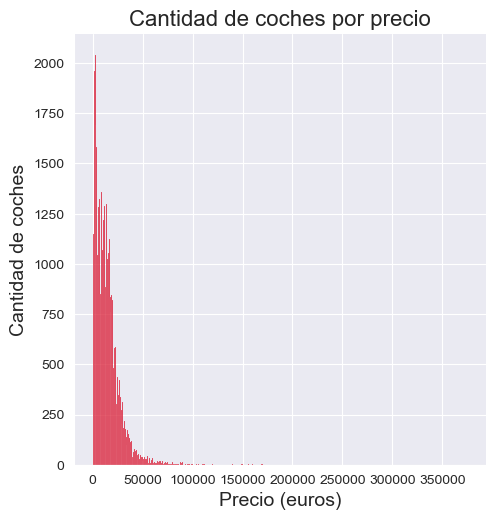

In [282]:
plt.figure(figsize=(12, 8))

sns.displot(df["precio"], color=colors[0])

plt.title("Cantidad de coches por precio", fontsize=16)

plt.xlabel("Precio (euros)", fontsize=14)
plt.ylabel("Cantidad de coches", fontsize=14)

plt.show()

Vemos que existen muchos coches con un precio más bajo, y que, para precios más elevados, se reduce el número. Para corregir esto, y aumentar la eficacia del modelo predictivo, vamos a tomar dos medidas:

1. Realizar un boxplot para detectar outliers y poder eliminar estos registros.

2. Aplicar una transformación logarítmica a la columna ```"precio"```, de modo que los datos tiendan a una distribución normal. Al final, cuando ya esté hecho el modelo, habrá que deshacer esta transformación para obtener el precio real del vehículo a predecir.

Comenzamos realizando el Boxplot:

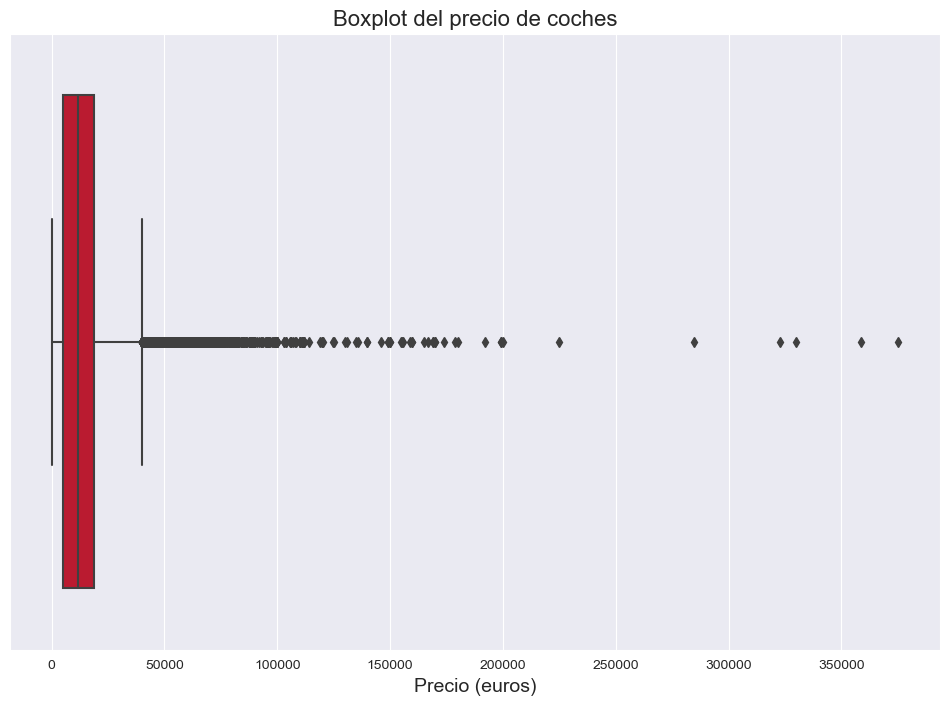

In [283]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))

# Boxplot de la variable "precio"
sns.boxplot(x=df["precio"], color=colors[0])

# Títulos y etiquetas
plt.title("Boxplot del precio de coches", fontsize=16)
plt.xlabel("Precio (euros)", fontsize=14)

plt.show()


Vemos que la distribución del boxplot muestra que el 75 % de los registros se concentran por debajo de los 20.000 euros aproximadamente.

Vamos a ver las principales medidas estadísticas de la variable ```"precio"```:

In [284]:
df["precio"].describe()

count     36609.000000
mean      14266.503128
std       13697.924567
min         300.000000
25%        5000.000000
50%       11500.000000
75%       18990.000000
max      375000.000000
Name: precio, dtype: float64

Observamos que la variable tiene una media de 14.266 euros y una desviación estándar (sigma) de 13.697 euros. Sin embargo, el valor máximo es de 375.000 euros.

Ante esto, vamos a proponer dos opciones para eliminar outliers que puedan influir negativamente en el modelo o para los cuáles funcione muy mal.

1. Coger los valores dentro de los siguientes límites a partir del Rango intercuartílico (IQR), que marcarían los outliers tradicionales:

    - limite_inferior = Q1 - 1.5 * IQR
    - limite_superior = Q3 + 1.5 * IQR

Probamos esta opción:


Opción con cuartiles:

In [285]:
# Calculamos Q1, Q3 e IQR
Q1 = df["precio"].quantile(0.25)
Q3 = df["precio"].quantile(0.75)
IQR = Q3 - Q1

# Límites inferior y superior para considerar outliers
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

print(f"Límite de precio inferior: {limite_inferior}")
print(f"Límite de precio superior: {limite_superior}")

df_iqr = df[(df["precio"] >= limite_inferior) & (df["precio"] <= limite_superior)]

print(f"Número de coches antes de eliminar outliers: {len(df)}")
print(f"Número de coches después de eliminar outliers: {len(df_iqr)}")


Límite de precio inferior: -15985.0
Límite de precio superior: 39975.0
Número de coches antes de eliminar outliers: 36609
Número de coches después de eliminar outliers: 35228


Si utilizamos esta opción seguro que el modelo funciona muy bien pero solo predeciríamos vehículos con precios hasta 39.975 euros, lo que dejaría fuera muchos modelos.

Por ello, vamos a descartar esta opción.

Probaremos una segunda opción que consiste en aplicar una transformación logarítmica a la columna ```"precio"```, de modo que los datos tiendan a una distribución normal. Después, nos quedaremos con los vehículos en un rango de valores del precio transformado de 2 desviaciones estandar a partir de la media, que coresponderá a un porcentaje muy elevado de los datos.

Al final, cuando ya esté hecho el modelo, habrá que deshacer esta transformación para obtener el precio real del vehículo a predecir.

Aplicamos la transformación logarítmica:

In [286]:
import numpy as np

# Transformación logarítmica del precio:
df["precio"] = np.log(df["precio"])

c:\Users\alberto.pintos\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\alberto.pintos\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1200x800 with 0 Axes>

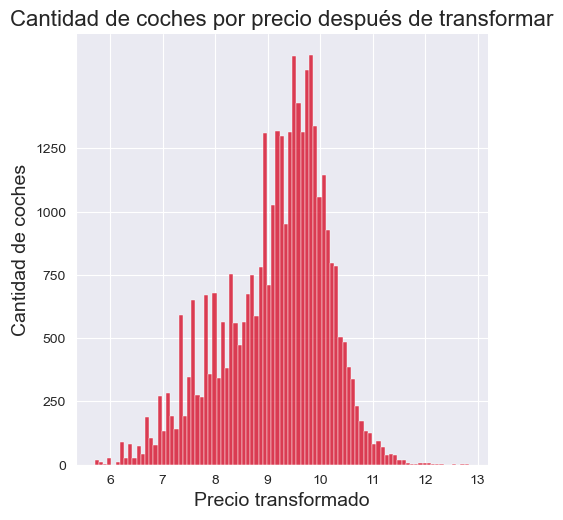

In [287]:
plt.figure(figsize=(12, 8))

sns.displot(df["precio"], color=colors[0])

plt.title("Cantidad de coches por precio después de transformar", fontsize=16)

plt.xlabel("Precio transformado", fontsize=14)
plt.ylabel("Cantidad de coches", fontsize=14)

plt.yticks(range(0, 1500, 250))

plt.show()

Test de normalidad de Shapiro-Wilk:

In [288]:
from scipy.stats import shapiro

# Aplicar el test de Shapiro-Wilk a una muestra (máx. 5000 datos recomendado)
sample = df["precio"].sample(n=5000, random_state=42)

stat, p_value = shapiro(sample)

print(f"Estadístico W: {stat:.4f}")
print(f"Valor p: {p_value:.4f}")

if p_value > 0.05:
    print("No se rechaza H₀: los datos podrían ser normales.")
else:
    print("Se rechaza H₀: los datos no siguen una distribución normal.")


Estadístico W: 0.9656
Valor p: 0.0000
Se rechaza H₀: los datos no siguen una distribución normal.


Nos quedamos con los valores dentro del límite superior de 2 sigmas:

In [289]:
mean_log = df["precio"].mean()
std_log = df["precio"].std()

# Límite superior a 2 sigmas en escala logarítmica:
upper_log_limit = mean_log + 2 * std_log

# Filtramos solo los valores dentro de las 2 sigmas:
df_filtrado = df[df["precio"] <= upper_log_limit]

# (Opcional) Si necesitamos volver a la escala original:
max_precio_filtrado = np.exp(upper_log_limit)

print(f"Límite superior en escala log: {upper_log_limit:.4f}")
print(f"Corresponde a un precio real de: {max_precio_filtrado:,.2f} €")

print(f"Número de coches antes de eliminar outliers: {len(df)}")
print(f"Número de coches después de eliminar outliers: {len(df_filtrado)}")


Límite superior en escala log: 11.1488
Corresponde a un precio real de: 69,478.24 €
Número de coches antes de eliminar outliers: 36609
Número de coches después de eliminar outliers: 36340


In [290]:
# Estadísticos de la variable precio transfromada:

df["precio"].describe()

count    36609.000000
mean         9.153885
std          0.997442
min          5.703782
25%          8.517193
50%          9.350102
75%          9.851668
max         12.834681
Name: precio, dtype: float64

Vemos que se eliminan 269 registros. Vamos a aplicar la transformación al df original y a ver los valores estadísticos transformados de nuevo, para ver que se ha realizado correctamente:

In [291]:
# Aplicamos el filtro de las 2 sigmas al df original:
df = df[df["precio"] <= upper_log_limit]

# Nuevos estadísticos tras el filtro:
df["precio"].describe()

count    36340.000000
mean         9.136934
std          0.981048
min          5.703782
25%          8.516993
50%          9.349232
75%          9.846917
max         11.147570
Name: precio, dtype: float64

Estos son los estadísticos que contiene la columna ```df["precio"]```, que ahora están en escala logarítmica, vamos a verlos en escala normal deshaciendo la transformación:

In [292]:
import numpy as np

# Mostramos el resumen estadístico con la transformación inversa (precio real)
print(np.exp(df["precio"]).describe())

count    36340.000000
mean     13639.849147
std      11027.933670
min        300.000000
25%       4999.000000
50%      11490.000000
75%      18900.000000
max      69395.000000
Name: precio, dtype: float64


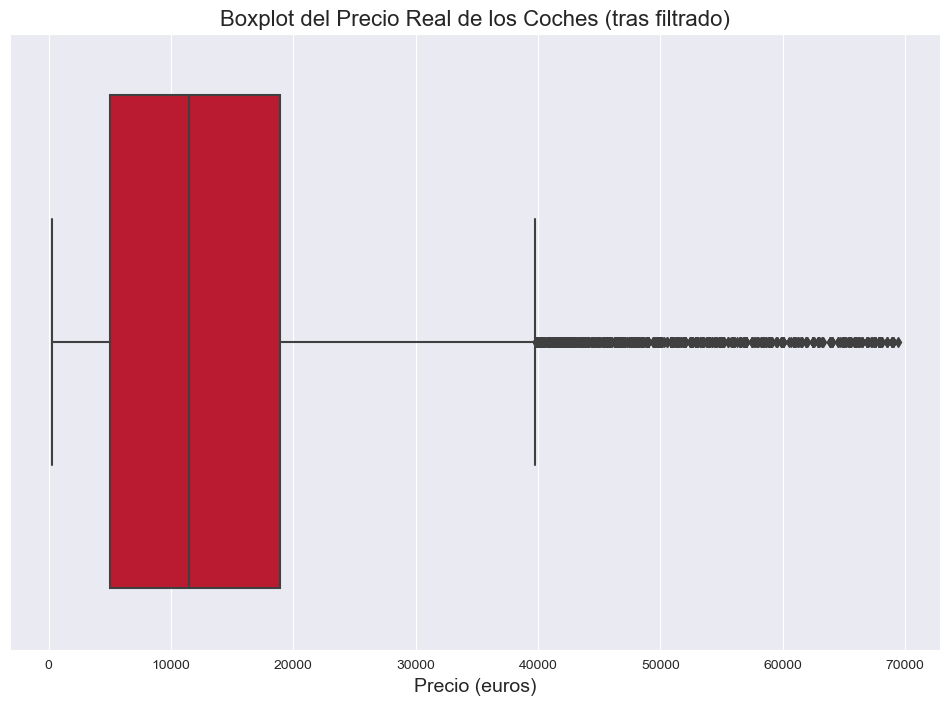

In [293]:
plt.figure(figsize=(12, 8))

# Boxplot con la transformación inversa de log(precio)
sns.boxplot(x=np.exp(df["precio"]), color=colors[0])

plt.title("Boxplot del Precio Real de los Coches (tras filtrado)", fontsize=16)
plt.xlabel("Precio (euros)", fontsize=14)

plt.show()


Vemos que sólo hemos perdido 269 vehículos pero ahora el precio máximo es de 69.395 euros, lo que comprende más vehículos y elimina outliers que el modelo podría predecir mal.

In [294]:
df.head()

,marca,modelo,precio,combustible,anyo_vehiculo,kilometraje,potencia,num_puertas,tipo_cambio,color,origen_anuncio
0,FORD,focus,9.740380,Gasolina,2019.0,75000,125.0,5.0,Manual,gris,WebScraping
1,OPEL,zafira tourer,9.358760,Diésel,2017.0,75150,120.0,5.0,Manual,gris,WebScraping
2,BMW,x3,10.542706,Híbrido,2021.0,33200,190.0,5.0,Automático,gris,WebScraping
3,PEUGEOT,308,9.104980,Gasolina,2016.0,127300,110.0,5.0,Manual,blanco,WebScraping
4,RENAULT,clio,9.391828,Diésel,2022.0,123000,100.0,5.0,Manual,blanco,WebScraping


Vemos que el precio ya no está en euros. Al final, cuando ya esté hecho el modelo, habrá que deshacer esta transformación para obtener el precio real del vehículo a predecir.

### Variables numéricas:

#### Potencia:

Vamos a analizar los nulos de la columna ```'potencia'```, a ver si son debidos al tipo de combustible o simplemente falta en esos registros.

In [295]:
df.groupby("combustible")["potencia"].apply(lambda x: x.isnull().sum())

combustible
Diesel                   3
Diésel                4880
Eléctrico                0
Gas licuado (GLP)        0
Gas natural (CNG)        0
Gasolina              1878
Híbrido                  0
Híbrido Enchufable       0
Híbrido enchufable       0
Name: potencia, dtype: int64

Como parece que hay varios formatos de la columna combustible, vamos a mapearlos:

In [296]:

mapa_combustible = {
    "Diesel": "Diésel",
    "Híbrido enchufable": "Híbrido Enchufable",
    "Híbrido Enchufable": "Híbrido Enchufable"
}

df["combustible"] = df["combustible"].replace(mapa_combustible)

In [297]:
df["combustible"].value_counts()

combustible
Diésel                24340
Gasolina              11026
Híbrido Enchufable      312
Eléctrico               285
Híbrido                 208
Gas natural (CNG)        58
Gas licuado (GLP)        49
Name: count, dtype: int64

In [298]:
df[df["potencia"].isna()].groupby("combustible").size()

combustible
Diésel      4883
Gasolina    1878
dtype: int64

Observamos que todos los nulos son para vehículos de gasolina o diésel, por lo que vamos a eliminar estos registros del DataFrame, ya que tenemos una cantidad de datos abundante y puede ser un parámetro sensible en el modelo, por lo que tratar de rellenar esos NaN por alguna métrica como la media, puede afectar negativamente.

In [299]:
df = df.drop(index=(df.loc[df.loc[:, "potencia"].isna() == True, :]).index)
df.head()

,marca,modelo,precio,combustible,anyo_vehiculo,kilometraje,potencia,num_puertas,tipo_cambio,color,origen_anuncio
0,FORD,focus,9.740380,Gasolina,2019.0,75000,125.0,5.0,Manual,gris,WebScraping
1,OPEL,zafira tourer,9.358760,Diésel,2017.0,75150,120.0,5.0,Manual,gris,WebScraping
2,BMW,x3,10.542706,Híbrido,2021.0,33200,190.0,5.0,Automático,gris,WebScraping
3,PEUGEOT,308,9.104980,Gasolina,2016.0,127300,110.0,5.0,Manual,blanco,WebScraping
4,RENAULT,clio,9.391828,Diésel,2022.0,123000,100.0,5.0,Manual,blanco,WebScraping


c:\Users\alberto.pintos\AppData\Local\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


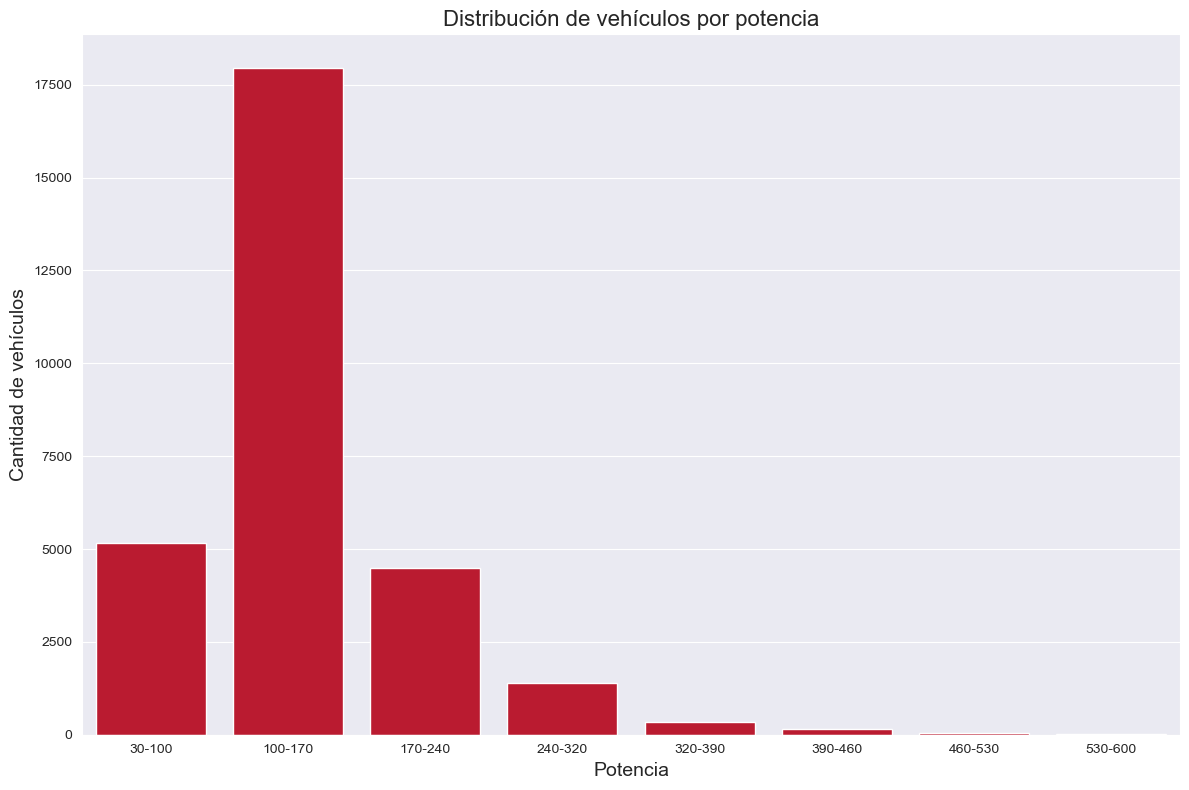

In [300]:
# Definimos los rangos de potencia:
min_potencia = df['potencia'].min()
max_potencia = df['potencia'].max()

num_bins = 8

bins = np.linspace(min_potencia, max_potencia, num_bins + 1) 
bins = np.round(bins, -1) 

labels = [f'{int(bins[i])}-{int(bins[i+1])}' for i in range(len(bins)-1)]

df_rangos = df.copy() 
df_rangos['potencia_rango'] = pd.cut(df_rangos['potencia'], bins=bins, labels=labels, right=False)

plt.figure(figsize = (12, 8))

sns.countplot(x=df_rangos["potencia_rango"], order=labels, color=colors[0])

plt.title("Distribución de vehículos por potencia", fontsize=16)
plt.xlabel("Potencia", fontsize=14)
plt.ylabel("Cantidad de vehículos", fontsize=14)
# plt.xticks(rotation=45)  

plt.xticks(ha='center') 
plt.tight_layout()

plt.show()

In [301]:
# Num de vehículos con potncia > 330 CV:

df.loc[df.loc[:, "potencia"] > 330, :].count()

marca             491
modelo            491
precio            491
combustible       491
anyo_vehiculo     491
kilometraje       491
potencia          491
num_puertas       491
tipo_cambio       491
color             491
origen_anuncio    491
dtype: int64

In [302]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29551 entries, 0 to 36608
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   marca           29551 non-null  object 
 1   modelo          29551 non-null  object 
 2   precio          29551 non-null  float64
 3   combustible     29517 non-null  object 
 4   anyo_vehiculo   29550 non-null  float64
 5   kilometraje     29551 non-null  int64  
 6   potencia        29551 non-null  float64
 7   num_puertas     29551 non-null  float64
 8   tipo_cambio     29471 non-null  object 
 9   color           29473 non-null  object 
 10  origen_anuncio  29551 non-null  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 2.7+ MB


#### Año:

In [303]:
# Vemos si hay alguno nulo:

df[df["anyo_vehiculo"].isna()]

,marca,modelo,precio,combustible,anyo_vehiculo,kilometraje,potencia,num_puertas,tipo_cambio,color,origen_anuncio
31004,SEAT,arona,10.021271,Gasolina,NaN,1,115.0,5.0,Manual,naranja,dataset kaggle


Vamos a ver la distribución de valores del campo ```"anyo_vehiculo"```.

Hay uno con valor nulo. Lo eliminamos y convertimos el resto a int:

In [304]:
df = df.dropna(subset=["anyo_vehiculo"])

df["anyo_vehiculo"] = df["anyo_vehiculo"].astype(int)

In [305]:
df["anyo_vehiculo"].value_counts()

anyo_vehiculo
2016    3813
2017    3066
2019    2999
2020    2760
2018    2507
2015    2159
2014    1335
2013     968
2007     959
2008     912
2011     897
2010     870
2012     830
2009     825
2006     786
2005     737
2004     576
2003     424
2021     397
2002     330
2001     255
2000     218
1999     163
2022     143
2023     113
1998      92
1997      62
2024      55
1996      50
1993      41
1995      33
1992      29
1994      28
1991      24
1989      24
1990      17
1988      11
1987       9
1986       8
1982       7
2025       6
1985       5
1984       3
1983       3
1980       1
Name: count, dtype: int64

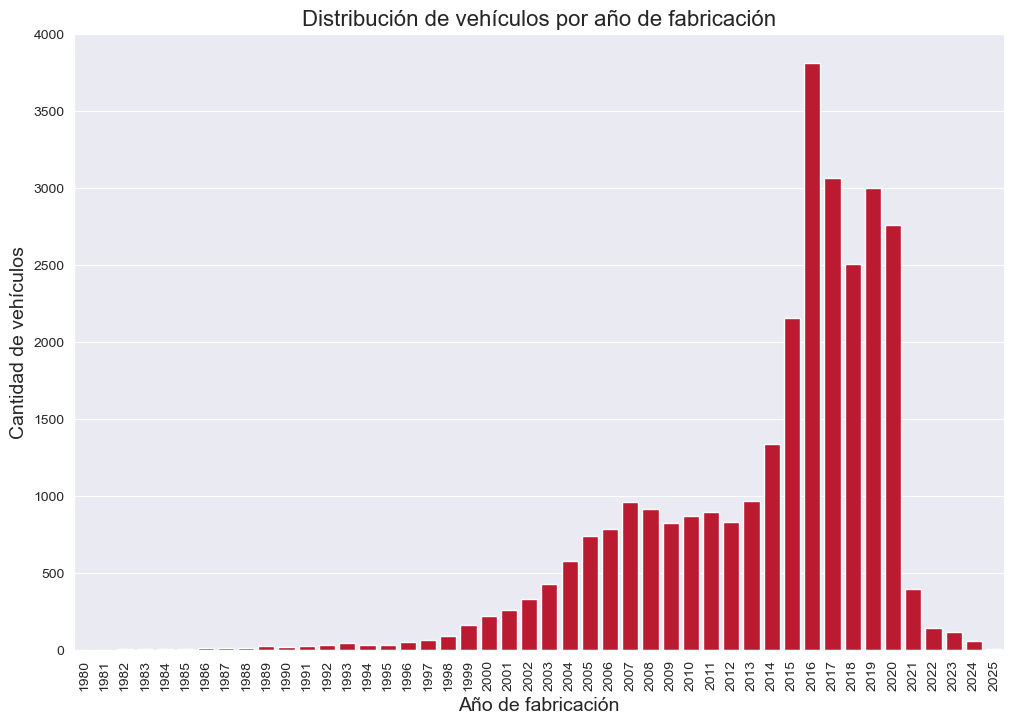

In [306]:
plt.figure(figsize = (12, 8))

rango_años = np.linspace(df["anyo_vehiculo"].min(), df["anyo_vehiculo"].max(), num=int(df["anyo_vehiculo"].max() - df["anyo_vehiculo"].min()) + 1, dtype=int)


sns.countplot(x=df["anyo_vehiculo"], order=rango_años, color=colors[0])

plt.title("Distribución de vehículos por año de fabricación", fontsize=16)
plt.xlabel("Año de fabricación", fontsize=14)
plt.ylabel("Cantidad de vehículos", fontsize=14)
plt.xticks(rotation=90)  

plt.show()

#### Número de puertas:

Veamos los valores de la siguiente columna no numérica, ```"num_puertas"```:

In [307]:
df["num_puertas"] = df["num_puertas"].astype(int)

df["num_puertas"].value_counts()

num_puertas
5    20900
4     5001
3     2158
2     1491
Name: count, dtype: int64

Vamos a agrupar los coches de 5 puertas con los de 4, y los de 3 con los de 2, ya que la diferencia es que no se cuenta el maletero.

In [308]:
num_puertas = {5: 5,
            4 : 5,
            3 : 3,
            2 : 3}
                     
df["num_puertas"] = df["num_puertas"].map(num_puertas)

In [309]:
df["num_puertas"].value_counts()

num_puertas
5    25901
3     3649
Name: count, dtype: int64

In [310]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29550 entries, 0 to 36608
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   marca           29550 non-null  object 
 1   modelo          29550 non-null  object 
 2   precio          29550 non-null  float64
 3   combustible     29516 non-null  object 
 4   anyo_vehiculo   29550 non-null  int32  
 5   kilometraje     29550 non-null  int64  
 6   potencia        29550 non-null  float64
 7   num_puertas     29550 non-null  int64  
 8   tipo_cambio     29470 non-null  object 
 9   color           29472 non-null  object 
 10  origen_anuncio  29550 non-null  object 
dtypes: float64(2), int32(1), int64(2), object(6)
memory usage: 2.6+ MB


### Variables categóricas:

#### Color:

La columna ```"color"``` sigue teniendo bastantes NaN.

In [311]:
pd.set_option("display.max_rows", None)

df["color"].value_counts()

color
blanco           7504
gris             7030
negro            4939
azul             3455
rojo             1676
Blanco            600
marrón            477
beige             401
verde             320
Gris / Plata      317
granate           264
Negro             239
naranja           185
Azul              172
amarillo          162
Rojo              138
300               104
475                71
2t2t               54
b4b4               51
violeta            38
x3x3               34
0q0q               31
2y2y               31
0e0e               30
b39                29
668                28
a83                25
8e8e               24
gaz                23
149                22
Naranja            22
h7h7               21
369                21
k5k5               21
a89                19
c10                18
0c0c               18
Beige              16
a96                15
l5l5               15
a90                15
y1y1               14
m0f4               14
4m4m               13
197 

Vamos a eliminar la columna color, ya que es una columna categórica con 323 valores únicos y algunos pueden estar en una codificación numérica y otros están mal guardados.

In [312]:
df = df.drop(columns="color")

In [313]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29550 entries, 0 to 36608
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   marca           29550 non-null  object 
 1   modelo          29550 non-null  object 
 2   precio          29550 non-null  float64
 3   combustible     29516 non-null  object 
 4   anyo_vehiculo   29550 non-null  int32  
 5   kilometraje     29550 non-null  int64  
 6   potencia        29550 non-null  float64
 7   num_puertas     29550 non-null  int64  
 8   tipo_cambio     29470 non-null  object 
 9   origen_anuncio  29550 non-null  object 
dtypes: float64(2), int32(1), int64(2), object(5)
memory usage: 2.4+ MB


#### Tipo de cambio:

La columna ```"tipo_cambio"``` también continúa teniendo bastantes NaN.

In [314]:
df["tipo_cambio"].value_counts(dropna=False)

tipo_cambio
Manual        19878
Automático     9592
None             80
Name: count, dtype: int64

Como en la columna ```"tipo_cambio"``` existen muchos coches manuales y automáticos, vamos a eliminar las filas con valores de ```"tipo_cambio"``` nulos (111).

In [315]:
df = df.drop(index=(df.loc[df.loc[:, "tipo_cambio"].isna() == True, :]).index)
df.head()

,marca,modelo,precio,combustible,anyo_vehiculo,kilometraje,potencia,num_puertas,tipo_cambio,origen_anuncio
0,FORD,focus,9.740380,Gasolina,2019,75000,125.0,5,Manual,WebScraping
1,OPEL,zafira tourer,9.358760,Diésel,2017,75150,120.0,5,Manual,WebScraping
2,BMW,x3,10.542706,Híbrido,2021,33200,190.0,5,Automático,WebScraping
3,PEUGEOT,308,9.104980,Gasolina,2016,127300,110.0,5,Manual,WebScraping
4,RENAULT,clio,9.391828,Diésel,2022,123000,100.0,5,Manual,WebScraping


In [316]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29470 entries, 0 to 36608
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   marca           29470 non-null  object 
 1   modelo          29470 non-null  object 
 2   precio          29470 non-null  float64
 3   combustible     29436 non-null  object 
 4   anyo_vehiculo   29470 non-null  int32  
 5   kilometraje     29470 non-null  int64  
 6   potencia        29470 non-null  float64
 7   num_puertas     29470 non-null  int64  
 8   tipo_cambio     29470 non-null  object 
 9   origen_anuncio  29470 non-null  object 
dtypes: float64(2), int32(1), int64(2), object(5)
memory usage: 2.4+ MB


Ahora que ya no contiene nulos, convertimos a numéricos los valores de la columna ```"tipo_cambio"```, mapeando como 0 los vehículos con cambio "Manual" y 1 los que tienen "Automático":

In [317]:
df["tipo_cambio"].value_counts()

tipo_cambio
Manual        19878
Automático     9592
Name: count, dtype: int64

In [318]:
df["tipo_cambio"] = df["tipo_cambio"].apply(lambda x: 0 if x == "Manual" else 1)

In [319]:
df["tipo_cambio"].value_counts()

tipo_cambio
0    19878
1     9592
Name: count, dtype: int64

In [320]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29470 entries, 0 to 36608
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   marca           29470 non-null  object 
 1   modelo          29470 non-null  object 
 2   precio          29470 non-null  float64
 3   combustible     29436 non-null  object 
 4   anyo_vehiculo   29470 non-null  int32  
 5   kilometraje     29470 non-null  int64  
 6   potencia        29470 non-null  float64
 7   num_puertas     29470 non-null  int64  
 8   tipo_cambio     29470 non-null  int64  
 9   origen_anuncio  29470 non-null  object 
dtypes: float64(2), int32(1), int64(3), object(4)
memory usage: 2.4+ MB


#### Combustible:

In [321]:
df[df["combustible"].isna()].count()

marca             34
modelo            34
precio            34
combustible        0
anyo_vehiculo     34
kilometraje       34
potencia          34
num_puertas       34
tipo_cambio       34
origen_anuncio    34
dtype: int64

Todavía hay 34 registros con el valor de combustible nulo, de modo que eliminamos estos registros:

In [322]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29436 entries, 0 to 36608
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   marca           29436 non-null  object 
 1   modelo          29436 non-null  object 
 2   precio          29436 non-null  float64
 3   combustible     29436 non-null  object 
 4   anyo_vehiculo   29436 non-null  int32  
 5   kilometraje     29436 non-null  int64  
 6   potencia        29436 non-null  float64
 7   num_puertas     29436 non-null  int64  
 8   tipo_cambio     29436 non-null  int64  
 9   origen_anuncio  29436 non-null  object 
dtypes: float64(2), int32(1), int64(3), object(4)
memory usage: 2.4+ MB


Vemos que nos hemos quedado con 29698 filas de 10 marcas de vehículos. Ya no tenemos valores nulos, ahora vamos a procesar las columnas restantes para que puedan ser usadas en el modelo.

In [323]:
df["combustible"].value_counts()

combustible
Diésel                19396
Gasolina               9128
Híbrido Enchufable      312
Eléctrico               285
Híbrido                 208
Gas natural (CNG)        58
Gas licuado (GLP)        49
Name: count, dtype: int64

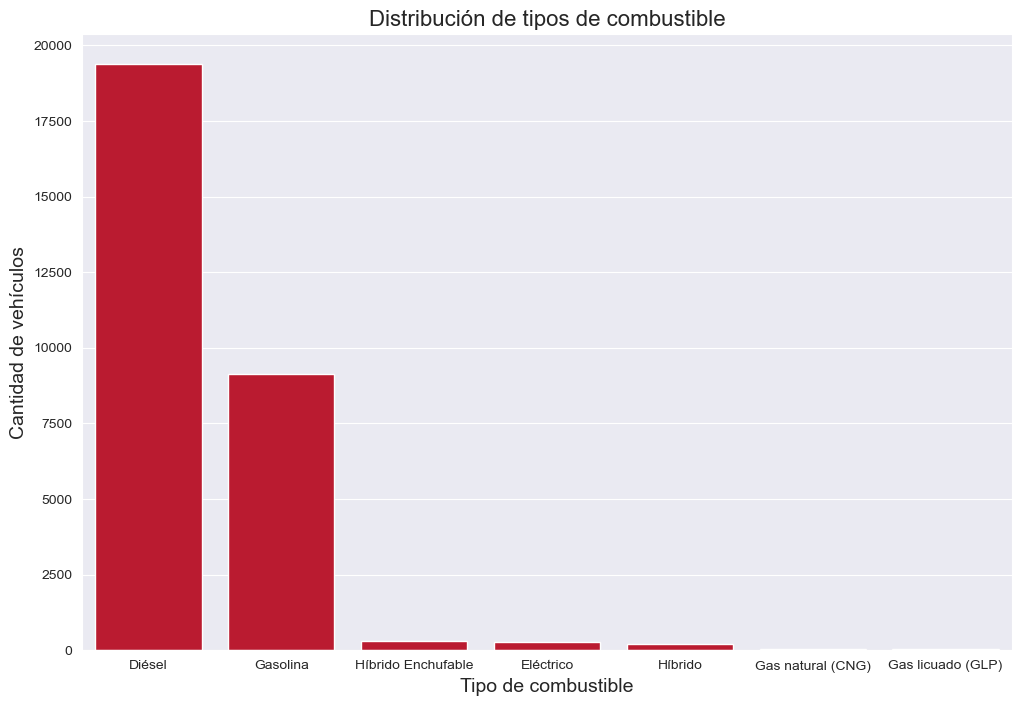

In [324]:
plt.figure(figsize = (12, 8))

sns.countplot(x=df["combustible"], order=df["combustible"].value_counts(ascending=False).index, color=colors[0])

plt.title("Distribución de tipos de combustible", fontsize=16)
plt.xlabel("Tipo de combustible", fontsize=14)
plt.ylabel("Cantidad de vehículos", fontsize=14)
# plt.xticks(rotation=45)  

plt.show()

In [325]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29436 entries, 0 to 36608
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   marca           29436 non-null  object 
 1   modelo          29436 non-null  object 
 2   precio          29436 non-null  float64
 3   combustible     29436 non-null  object 
 4   anyo_vehiculo   29436 non-null  int32  
 5   kilometraje     29436 non-null  int64  
 6   potencia        29436 non-null  float64
 7   num_puertas     29436 non-null  int64  
 8   tipo_cambio     29436 non-null  int64  
 9   origen_anuncio  29436 non-null  object 
dtypes: float64(2), int32(1), int64(3), object(4)
memory usage: 2.4+ MB


Vamos ahora a convertir la columna ```"combustible"``` en numérica a través de un mapeado:

In [326]:
df["combustible"].value_counts()

combustible
Diésel                19396
Gasolina               9128
Híbrido Enchufable      312
Eléctrico               285
Híbrido                 208
Gas natural (CNG)        58
Gas licuado (GLP)        49
Name: count, dtype: int64

Vemos cómo predominan los coches de diésel y gasolina.

Convertimos los valores en numéricos utilizando un mapeado:

In [327]:
# Aplicamos un mapeado para la columna "combustible":

tipos_combutible = {"Diésel" : 0,
            "Gasolina" : 1,
            "Híbrido" : 2,
            "Eléctrico" : 3,
            "Híbrido Enchufable" : 4, 
            "Gas licuado (GLP)" : 5,
            "Gas natural (CNG)" : 6}
                     
df["combustible"] = df["combustible"].map(tipos_combutible)

In [328]:
df["combustible"].value_counts()

combustible
0    19396
1     9128
4      312
3      285
2      208
6       58
5       49
Name: count, dtype: int64

In [329]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29436 entries, 0 to 36608
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   marca           29436 non-null  object 
 1   modelo          29436 non-null  object 
 2   precio          29436 non-null  float64
 3   combustible     29436 non-null  int64  
 4   anyo_vehiculo   29436 non-null  int32  
 5   kilometraje     29436 non-null  int64  
 6   potencia        29436 non-null  float64
 7   num_puertas     29436 non-null  int64  
 8   tipo_cambio     29436 non-null  int64  
 9   origen_anuncio  29436 non-null  object 
dtypes: float64(2), int32(1), int64(4), object(3)
memory usage: 2.4+ MB


#### Marca:

Antes de convertir las columnas ```"marca"``` y ```"modelo"``` en númericas, vamos a guardar en un set las marcas y modelos de coches que quedan en el DataFrame, para luego utilizarlas en la Web App de predicción de precios:

In [330]:
df.head()

,marca,modelo,precio,combustible,anyo_vehiculo,kilometraje,potencia,num_puertas,tipo_cambio,origen_anuncio
0,FORD,focus,9.740380,1,2019,75000,125.0,5,0,WebScraping
1,OPEL,zafira tourer,9.358760,0,2017,75150,120.0,5,0,WebScraping
2,BMW,x3,10.542706,2,2021,33200,190.0,5,1,WebScraping
3,PEUGEOT,308,9.104980,1,2016,127300,110.0,5,0,WebScraping
4,RENAULT,clio,9.391828,0,2022,123000,100.0,5,0,WebScraping


In [331]:
marca_modelo_set = {}

for index, row in df.iterrows():
    make = row['marca']
    model = row['modelo']
    
    if make not in marca_modelo_set:
        marca_modelo_set[make] = {model}
    else:
        marca_modelo_set[make].add(model)

# Guardamos el set con marcas y modelos en un pkl:

with open('../include/utils/marca_modelo_set.pkl', 'wb') as archivo_salida3:
    pickle.dump(marca_modelo_set, archivo_salida3)

print(marca_modelo_set)

{'FORD': {'connect', 'escort', 'sierra', 'tourneo connect', 'maverick', 'c-max', 'transit custom', 'focus', 'capri', 's-max', 'mustang', 'fiesta', 'grand c-max', 'ranger', 'mondeo', 'grand tourneo connect', 'transit', 'puma', 'ka', 'b-max', 'courier', 'transit courier', 'kuga', 'transit connect', 'tourneo courier', 'probe', 'explorer', 'fusion', 'ka+', 'edge', 'ecosport', 'galaxy', 'tourneo custom', 'focus c-max', 'fiesta van'}, 'OPEL': {'corsa van', 'kadett', 'omega', 'grandland x phev', 'meriva', 'mokka', 'astra', 'cabrio', 'zafira tourer', 'movano', 'combo life', 'vivaro', 'grandland x', 'crossland x', 'monterey', 'corsa-e', 'karl', 'mokka x', 'adam', 'vectra', 'frontera', 'agila', 'manta', 'crossland', 'zafira life', 'gt', 'combo', 'gtc', 'signum', 'tigra', 'zafira-e life', 'antara', 'corsa', 'ampera', 'insignia', 'zafira'}, 'BMW': {'x6', 'serie 1', 'serie 6', 'x4', 'i3', 'serie 8', 'serie 4', 'serie 2 gran tourer', 'x1', 'i4 eDrive40', 'compact', 'ix3', 'z3', 'serie 3', 'serie 2',

Una vez guardado este set, empezamos con el análisis y procesado de las variables que utilizaremos en el modelo:

In [332]:
marca_df = df["marca"]
marca_df.value_counts()

marca
VOLKSWAGEN       3868
BMW              3749
MERCEDES-BENZ    3549
AUDI             3137
PEUGEOT          2780
FORD             2653
RENAULT          2615
OPEL             2520
CITROEN          2444
SEAT             2121
Name: count, dtype: int64

Tenemos 72 marcas diferentes de coches. Vamos a hacer un countplot para ver cuántos vehículos tenemos de cada marca:

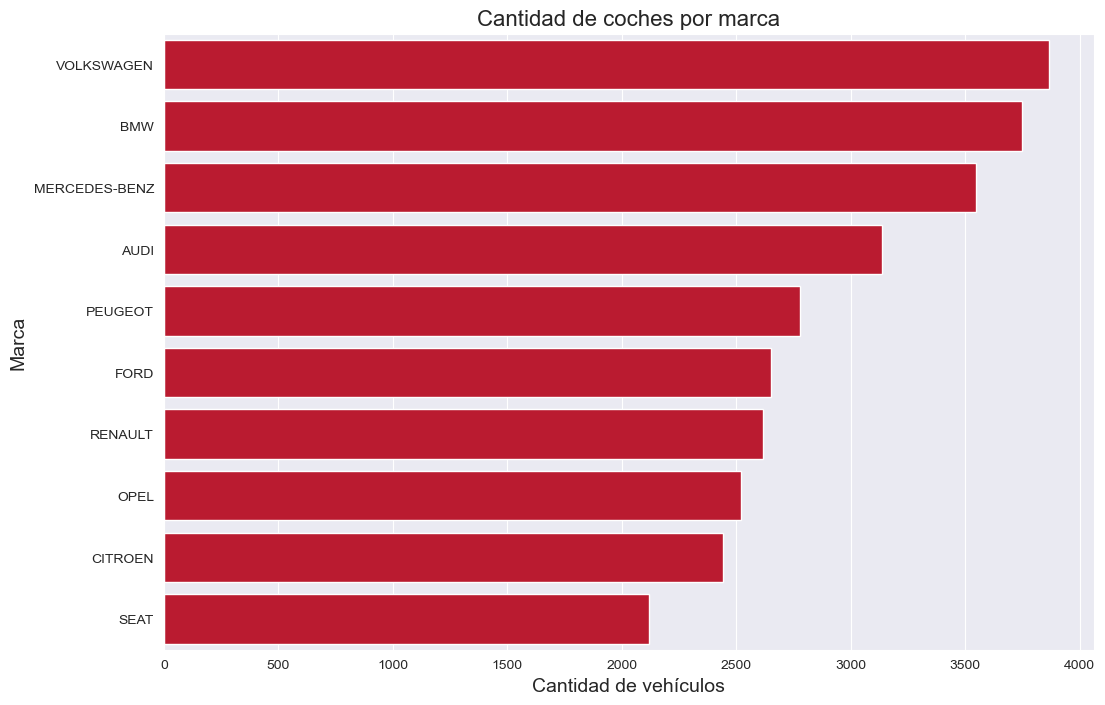

In [333]:
plt.figure(figsize = (12, 8))
sns.countplot(y = marca_df, order=marca_df.value_counts(ascending=False).index, color=colors[0])

plt.title("Cantidad de coches por marca", fontsize=16)
plt.xlabel("Cantidad de vehículos", fontsize=14)
plt.ylabel("Marca", fontsize=14)

plt.show()

En el gráfico vemos cómo tenemos muchos coches registrados en la base de datos para cada una de las 10 marcas.

Vamos a asignar un valor numérico a cada marca para poder utilizar dicha columna como feature del modelo:

In [334]:
# Asignamos cada marca a un valor numérico utilizando LabelEncoder:

from sklearn.preprocessing import LabelEncoder

encoder_marca = LabelEncoder()
encoder_marca.fit(df["marca"].sort_values(ascending=False))
list(encoder_marca.classes_)
df["marca"] = encoder_marca.transform(df["marca"])

# Guardamos el LabelEncoder para poder utilizarlo después en otros archivos:

with open('../include/utils/label_encoder_marca.pkl', 'wb') as archivo_salida1:
    pickle.dump(encoder_marca, archivo_salida1)

df["marca"].value_counts()

marca
9    3868
1    3749
4    3549
0    3137
6    2780
3    2653
7    2615
5    2520
2    2444
8    2121
Name: count, dtype: int64

In [335]:
# muestra las marcas originales

print(encoder_marca.classes_) 


['AUDI' 'BMW' 'CITROEN' 'FORD' 'MERCEDES-BENZ' 'OPEL' 'PEUGEOT' 'RENAULT'
 'SEAT' 'VOLKSWAGEN']


In [336]:
# Para visualizar el mapping de marca con LabelEncoder

list(encoder_marca.inverse_transform([0]))

['AUDI']

In [337]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29436 entries, 0 to 36608
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   marca           29436 non-null  int32  
 1   modelo          29436 non-null  object 
 2   precio          29436 non-null  float64
 3   combustible     29436 non-null  int64  
 4   anyo_vehiculo   29436 non-null  int32  
 5   kilometraje     29436 non-null  int64  
 6   potencia        29436 non-null  float64
 7   num_puertas     29436 non-null  int64  
 8   tipo_cambio     29436 non-null  int64  
 9   origen_anuncio  29436 non-null  object 
dtypes: float64(2), int32(2), int64(4), object(2)
memory usage: 2.2+ MB


#### Modelo:

Vamos ahora con la columna ```"modelo"```:

In [338]:
df["modelo"].value_counts()

modelo
golf                                   1224
serie 3                                 982
a3                                      751
clase c                                 729
a4                                      725
focus                                   719
serie 1                                 707
megane                                  702
ibiza                                   692
leon                                    673
astra                                   633
corsa                                   594
passat                                  553
308                                     551
clio                                    539
clase a                                 487
polo                                    487
c3                                      453
fiesta                                  429
serie 5                                 391
clase e                                 386
insignia                                342
c4                       

Tenemos 373 modelos diferentes. En esta ocasión no realizamos el countplot ya que es información demasiado específica para visualizar.

Aunque son muchos valores diferentes, por el momento, realizamos otro Label Encoder. Más adelante veremos si es una columna que aporte información al modelo.

In [339]:
from sklearn.preprocessing import LabelEncoder

encoder_modelo = LabelEncoder()
encoder_modelo.fit(df["modelo"].sort_values(ascending=False))
list(encoder_modelo.classes_)
df["modelo"] = encoder_modelo.transform(df["modelo"])

# Guardamos el Encoding:

with open('../include/utils/label_encoder_modelo.pkl', 'wb') as archivo_salida2:
    pickle.dump(encoder_modelo, archivo_salida2)

df["modelo"].value_counts()

modelo
192    1224
303     982
53      751
118     729
54      725
182     719
299     707
245     702
212     692
235     673
74      633
153     594
261     553
29      551
142     539
116     487
264     487
91      453
179     429
305     391
124     386
215     342
95      287
24      280
347     269
17      269
251     265
57      258
56      258
321     258
79      254
10      254
232     240
325     236
71      233
41      224
304     223
117     220
349     207
127     196
39      195
351     191
268     189
270     188
51      187
111     180
120     170
259     167
97      166
128     161
196     160
297     156
202     152
87      152
108     151
75      144
344     136
92      128
224     128
98      127
15      127
359     123
298     120
271     117
233     114
168     113
101     110
250     109
302     109
352     102
140     101
86       98
300      97
133      94
287      90
226      88
301      86
204      83
135      82
307      82
267      79
350      79
334      

In [340]:
# Para visualizar el mapping de model con LabelEncoder

list(encoder_modelo.inverse_transform([196]))

['grand c4 picasso']

In [341]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29436 entries, 0 to 36608
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   marca           29436 non-null  int32  
 1   modelo          29436 non-null  int32  
 2   precio          29436 non-null  float64
 3   combustible     29436 non-null  int64  
 4   anyo_vehiculo   29436 non-null  int32  
 5   kilometraje     29436 non-null  int64  
 6   potencia        29436 non-null  float64
 7   num_puertas     29436 non-null  int64  
 8   tipo_cambio     29436 non-null  int64  
 9   origen_anuncio  29436 non-null  object 
dtypes: float64(2), int32(3), int64(4), object(1)
memory usage: 2.1+ MB


#### Origen anuncio:

Tan solo falta la columna ```"origen_anuncio"```, que vamos a eliminar ya que sólo la hemos mantenido para diferenciar el origen del anuncio, pero no la queremos utilizar en el modelo predictivo.

In [342]:
df.drop(columns=["origen_anuncio"], inplace=True)

In [343]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29436 entries, 0 to 36608
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   marca          29436 non-null  int32  
 1   modelo         29436 non-null  int32  
 2   precio         29436 non-null  float64
 3   combustible    29436 non-null  int64  
 4   anyo_vehiculo  29436 non-null  int32  
 5   kilometraje    29436 non-null  int64  
 6   potencia       29436 non-null  float64
 7   num_puertas    29436 non-null  int64  
 8   tipo_cambio    29436 non-null  int64  
dtypes: float64(2), int32(3), int64(4)
memory usage: 1.9 MB


Ya tenemos nuestro DataFrame con todas las columnas de tipo numérico, listas para ser utilizadas por el modelo (después de escalar, dividir los conjuntos de train y test, etc.).

Guardamos el DataFrame.

In [50]:
# Guardamos el DataFrame transformado

df.to_csv("../include/data/processed/df_pre_modelo.csv")

## 3. Modelos predictivos.

In [52]:
df = pd.read_csv("../include/data/processed/df_pre_modelo.csv", index_col=0).reset_index(drop=True)
df

,marca,modelo,precio,combustible,anyo_vehiculo,kilometraje,potencia,num_puertas,tipo_cambio
0,1,356,37900.0,2,2021.0,33200,190.0,5,1
1,6,29,9000.0,1,2016.0,127300,110.0,5,0
2,7,143,11990.0,0,2022.0,123000,100.0,5,0
3,2,92,16500.0,1,2022.0,18150,83.0,5,0
4,9,110,67900.0,0,2023.0,12000,150.0,5,1
...,...,...,...,...,...,...,...,...,...
29694,8,239,18590.0,0,2019.0,21153,115.0,5,0
29695,7,237,14500.0,0,2015.0,68750,150.0,3,0
29696,6,5,11000.0,1,2019.0,21422,72.0,5,0
29697,0,289,47900.0,1,2013.0,47900,450.0,5,1


Ya tenemos 9 columnas numéricas con las que poder predecir la columna target (```"precio"```).

Vamos ahora a dividir los datos de X (features) e y (target).

In [57]:
X = df.drop("precio", axis=1)
y = df["precio"]

In [58]:
X

,marca,modelo,combustible,anyo_vehiculo,kilometraje,potencia,num_puertas,tipo_cambio
0,1,356,2,2021.0,33200,190.0,5,1
1,6,29,1,2016.0,127300,110.0,5,0
2,7,143,0,2022.0,123000,100.0,5,0
3,2,92,1,2022.0,18150,83.0,5,0
4,9,110,0,2023.0,12000,150.0,5,1
...,...,...,...,...,...,...,...,...
29694,8,239,0,2019.0,21153,115.0,5,0
29695,7,237,0,2015.0,68750,150.0,3,0
29696,6,5,1,2019.0,21422,72.0,5,0
29697,0,289,1,2013.0,47900,450.0,5,1


Vamos a realizar un heatmap de las features de nuestro modelo, para ver cómo de correlacionadas están entre ellas:

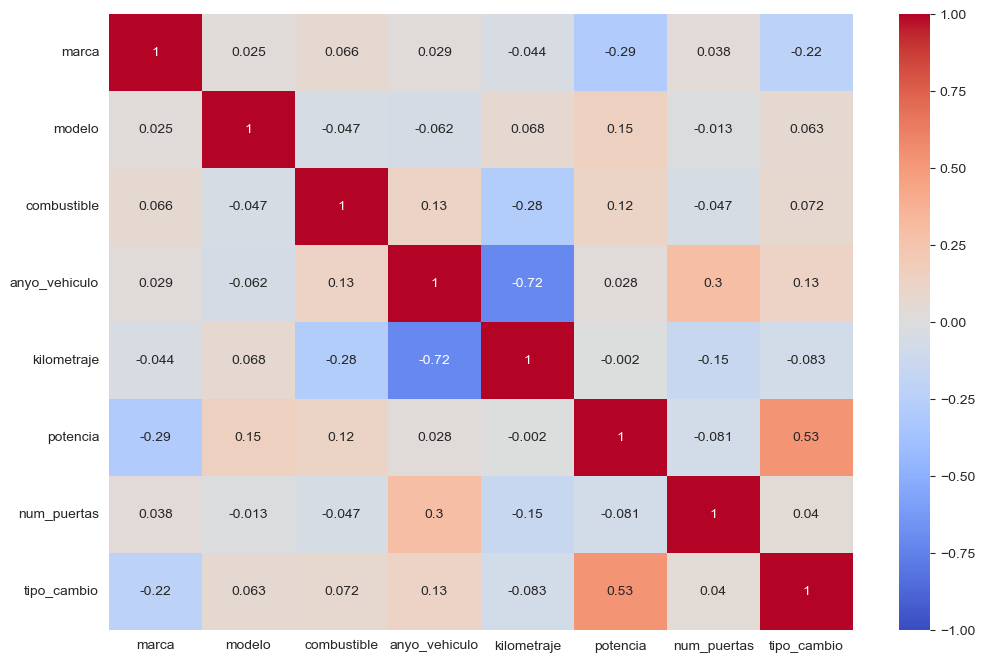

In [59]:
matriz_corr = X.corr(numeric_only=True).round(decimals=3)

plt.figure(figsize=(12, 8))

sns.heatmap(matriz_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

plt.show()

Vemos que la mayor correlación se da entre los kilómetros y el año del vehículo, y es negativa. Esto es lógico, ya que cuanto mayor sea el año (y más nuevo el coche), menor suele ser el número de kilómetros realizados.

Además de esto, cabe mencionar que ninguna de las correlaciones es lo suficientemente elevada como para plantearse prescindir de alguna columna.

Separamos los datos de train y test:

In [60]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(23759, 8)
(5940, 8)
(23759,)
(5940,)


Vamos a escalar los datos de X entre 0 y 1:

In [61]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train)

# Guardamos el Scaler

with open('../include/utils/scaler.pkl', 'wb') as archivo_salida4:
    pickle.dump(scaler, archivo_salida4)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [62]:
X_train

array([[0.22222222, 0.24797844, 0.16666667, ..., 0.08688525, 1.        ,
        0.        ],
       [0.11111111, 0.83557951, 0.16666667, ..., 0.48688525, 0.        ,
        1.        ],
       [0.        , 0.14555256, 0.        , ..., 0.18196721, 1.        ,
        0.        ],
       ...,
       [0.88888889, 0.64420485, 0.16666667, ..., 0.14098361, 1.        ,
        0.        ],
       [0.77777778, 0.38544474, 0.        , ..., 0.07540984, 1.        ,
        0.        ],
       [0.33333333, 0.50943396, 0.16666667, ..., 0.14098361, 1.        ,
        0.        ]])

Comenzamos la seleción del modelo de regresión. Para ello, probamos varias parametrizaciones de modelos utilizando GridSearchCV.

In [ ]:
# Importamos los modelos de regresión que utilizaremos

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

import xgboost

from sklearn.ensemble import VotingRegressor

from sklearn.model_selection import GridSearchCV

from sklearn import metrics

In [66]:
# LinearRegression??

### 3.1. Linear Regression.

In [67]:
# Linear Regression

param = {}

gs_lin_reg = GridSearchCV(estimator=LinearRegression(), param_grid=param, cv=5, scoring="neg_mean_squared_error")

gs_lin_reg.fit(X_train, y_train)

y_pred = gs_lin_reg.predict(X_test)

print(f"MSE: {metrics.mean_squared_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}")
print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred)}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(y_test, y_pred)}")

print(f"r2 score: {metrics.r2_score(y_test, y_pred)}")

MSE: 0.11461013111805038
RMSE: 0.33854118083041296
MAE: 0.23870741331869805
MAPE: 0.0261976080078374
r2 score: 0.8350559570096232


### 3.2. Polynomial Regression.

In [70]:
# Polynomial Regression

param = {}

for degree in range(1, 6):

    poly_feat = PolynomialFeatures(degree = degree)

    poly_feat.fit(X_train)

    X_train_poly = poly_feat.transform(X_train)
    X_test_poly = poly_feat.transform(X_test)


    gs_poly = GridSearchCV(estimator=LinearRegression(), param_grid=param, cv=5, scoring="neg_mean_squared_error")

    gs_poly.fit(X_train_poly, y_train)

    y_pred = gs_poly.predict(X_test_poly)

    print(f"Poly Degree {degree}:")

    print(f"MSE: {metrics.mean_squared_error(y_test, y_pred)}")
    print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}")
    print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred)}")
    print(f"MAPE: {metrics.mean_absolute_percentage_error(y_test, y_pred)}")

    print(f"r2 score: {metrics.r2_score(y_test, y_pred)}")
    print(" ")

Poly Degree 1:
MSE: 0.11461013111804957
RMSE: 0.3385411808304118
MAE: 0.23870741331869574
MAPE: 0.026197608007837523
r2 score: 0.8350559570096244
 
Poly Degree 2:
MSE: 0.08969448465760148
RMSE: 0.2994903748997645
MAE: 0.20880008952004817
MAPE: 0.02296056967485811
r2 score: 0.8709139341431829
 
Poly Degree 3:
MSE: 0.07531957401464005
RMSE: 0.2744441182001175
MAE: 0.1849798011154453
MAPE: 0.02045669961142007
r2 score: 0.891601947113286
 
Poly Degree 4:
MSE: 0.07132395700256919
RMSE: 0.26706545452860275
MAE: 0.17608620688370796
MAPE: 0.019463395613474915
r2 score: 0.8973523394894474
 
Poly Degree 5:
MSE: 0.0712422159219938
RMSE: 0.2669123749884853
MAE: 0.17137233242708003
MAPE: 0.018930735957661968
r2 score: 0.897469979214461
 


In [71]:
# El mejor es el de grado 5:

degree = 5
poly_feat = PolynomialFeatures(degree = degree)

poly_feat.fit(X_train)

X_train_poly = poly_feat.transform(X_train)
X_test_poly = poly_feat.transform(X_test)


best_poly_model = GridSearchCV(estimator=LinearRegression(), param_grid=param, cv=5, scoring="neg_mean_squared_error")

best_poly_model.fit(X_train_poly, y_train)

y_pred = best_poly_model.predict(X_test_poly)

print(f"Poly Degree {degree}:")

print(f"MSE: {metrics.mean_squared_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}")
print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred)}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(y_test, y_pred)}")

print(f"r2 score: {metrics.r2_score(y_test, y_pred)}")

Poly Degree 5:
MSE: 0.0712422159219938
RMSE: 0.2669123749884853
MAE: 0.17137233242708003
MAPE: 0.018930735957661968
r2 score: 0.897469979214461


### 3.3. RandomForest.

In [72]:
# RandomForest

param = {"n_estimators":[50, 100, 300], "max_depth":[3, 5, 9, 15, 33], "n_jobs":[-1], "random_state":[42]}

gs_rf = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param, cv=5, scoring="neg_mean_squared_error")

gs_rf.fit(X_train, y_train)

y_pred = gs_rf.predict(X_test)

print(f"MSE: {metrics.mean_squared_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}")
print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred)}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(y_test, y_pred)}")

print(f"r2 score: {metrics.r2_score(y_test, y_pred)}")

MSE: 0.05245973242634091
RMSE: 0.2290408968423345
MAE: 0.1432143737308114
MAPE: 0.0159770832604703
r2 score: 0.9245012611347475


In [73]:
gs_rf.best_params_

{'max_depth': 33, 'n_estimators': 300, 'n_jobs': -1, 'random_state': 42}

### 3.4. ADA Boost Regression.

In [74]:
# ADA

param = {"n_estimators":[50, 100, 300], "learning_rate":np.arange(0.1, 1.1, 0.1), "random_state":[42]}

gs_ada = GridSearchCV(estimator=AdaBoostRegressor(), param_grid=param, cv=5, scoring="neg_mean_squared_error")

gs_ada.fit(X_train, y_train)

y_pred = gs_ada.predict(X_test)

print(f"MSE: {metrics.mean_squared_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}")
print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred)}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(y_test, y_pred)}")

print(f"r2 score: {metrics.r2_score(y_test, y_pred)}")

MSE: 0.12913964574632744
RMSE: 0.3593600502926382
MAE: 0.2685003649807258
MAPE: 0.029238076979689855
r2 score: 0.8141454418387843


In [75]:
gs_ada.best_score_

-0.1272252746038315

In [76]:
gs_ada.best_params_

{'learning_rate': 0.4, 'n_estimators': 100, 'random_state': 42}

### 3.5. Gradient Boosting Regression.

In [77]:
# Gradient Boost

param = {"n_estimators":[50, 100, 300], "learning_rate":np.arange(0.1, 1.1, 0.1), "random_state":[42]}

gs_gb = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=param, cv=5, scoring="neg_mean_squared_error")

gs_gb.fit(X_train, y_train)

y_pred = gs_gb.predict(X_test)

print(f"MSE: {metrics.mean_squared_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}")
print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred)}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(y_test, y_pred)}")

print(f"r2 score: {metrics.r2_score(y_test, y_pred)}")

MSE: 0.04443449167430775
RMSE: 0.210794904289235
MAE: 0.14072856066304698
MAPE: 0.015624269353422865
r2 score: 0.9360509875219203


### 3.6. XGradient Boosting Regression.

In [78]:
# XG Boost

param = {}

gs_xgb = GridSearchCV(estimator=xgboost.XGBRegressor(), param_grid=param, cv=5, scoring="neg_mean_squared_error")

gs_xgb.fit(X_train, y_train)

y_pred = gs_xgb.predict(X_test)

print(f"MSE: {metrics.mean_squared_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}")
print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred)}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(y_test, y_pred)}")

print(f"r2 score: {metrics.r2_score(y_test, y_pred)}")

MSE: 0.04557942078419423
RMSE: 0.21349337409904373
MAE: 0.13764354696548495
MAPE: 0.015311936673952017
r2 score: 0.9344032340948909


### 3.7. Voting.

In [79]:
# Voting

# param = {"estimators":[gs_lin_reg.best_estimator_, best_poly_model.best_estimator_, gs_rf.best_estimator_, gs_ada.best_estimator_, gs_gb.best_estimator_, gs_xgb.best_estimator_],
#          "n_jobs":[-1]}

gs_voting = VotingRegressor(estimators=[("lin_reg", gs_lin_reg.best_estimator_), ("rf", gs_rf.best_estimator_), ("ada", gs_ada.best_estimator_), ("gb", gs_gb.best_estimator_), ("xgb", gs_xgb.best_estimator_)],
                            n_jobs=-1,)

gs_voting.fit(X_train, y_train)

y_pred = gs_voting.predict(X_test)

print(f"MSE: {metrics.mean_squared_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}")
print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred)}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(y_test, y_pred)}")

print(f"r2 score: {metrics.r2_score(y_test, y_pred)}")

MSE: 0.053497701952873
RMSE: 0.23129570240900066
MAE: 0.15609829313481452
MAPE: 0.017271840387161876
r2 score: 0.9230074412731275


El Voting da peor. El modelo con mejores métricas es el Gradient Boosting Regressor, aunque el XGradient Boosting y el RandomForest también estaba cerca. 

## 4. Selección y análisis del mejor modelo.

### 4.1. Selección de modelo:

Vamos a comparar en una tabla el resultado obtenido para el MSE de test en cada modelo, ya que es la métrica que estamos utilizando, con el fin de elegir el mejor:

In [2]:
import pandas as pd

In [4]:
df_comp_modelos_log = pd.DataFrame({"Modelo":["Linear Regression", "Polynomial Regression (grado 5)", "RandomForest", "ADA Boost", "Gradient Boost", "XG Boost", "Voting"],
                                "RMSE":[0.3385, 0.2669, 0.2290, 0.3594, 0.2108, 0.2135, 0.2313],
                                "MAE":[0.2387, 0.1714, 0.1432, 0.2685, 0.1407, 0.1376, 0.1561],
                                "r2 score":[0.8351, 0.8975, 0.9245, 0.8142, 0.9361, 0.9344, 0.9230]})

df_comp_modelos_log = df_comp_modelos_log.sort_values("MAE", ascending=True).reset_index(drop=True)
df_comp_modelos_log

,Modelo,RMSE,MAE,r2 score
0,XG Boost,0.2135,0.1376,0.9344
1,Gradient Boost,0.2108,0.1407,0.9361
2,RandomForest,0.2290,0.1432,0.9245
3,Voting,0.2313,0.1561,0.9230
4,Polynomial Regression (grado 5),0.2669,0.1714,0.8975
5,Linear Regression,0.3385,0.2387,0.8351
6,ADA Boost,0.3594,0.2685,0.8142


Vemos que el mejor modelo es el Gradient Boost, aunque está muy cerca el XGBoost. Vamos a quedarnos con el XGBoost, ya que su tiempo de entrenamiento es mucho menor y los resultados muy similares, y también con el RandomForest, ya que su funcionamiento es distinto y sus resultados están bastante cerca, por lo que puede sernos útil para comparar.

Cabe destacar que el MAE representado en la tabla anterior no se corresponde con el error medio en la predicción del modelo sobre el precio del vehículo, ya que hemos aplicado una transformación logarítmica a este precio. Más adelante veremos el MAE y el MSE reales del mejor modelo, una vez aplicada la transformación inversa. 

Vamos a ver si podemos mejorar algo de estos dos modelos mirando la importancia de las columnas (features) y realizando alguna modificación. Comenzamos con el RandomForest:

In [81]:
gs_rf.best_estimator_.feature_importances_

array([0.02460727, 0.0320876 , 0.00499191, 0.57098731, 0.07337544,
       0.28391704, 0.00341773, 0.00661569])

Realizamos un dataframe con la importancia de las cada columna en el modelo RandomForest:

In [89]:
df_feat_imp_rf = pd.DataFrame(gs_rf.best_estimator_.feature_importances_, index=X.columns)
df_feat_imp_rf = df_feat_imp_rf.rename(columns={0:"Feature Importance"}).sort_values("Feature Importance", ascending=False)
df_feat_imp_rf

,Feature Importance
anyo_vehiculo,0.570987
potencia,0.283917
kilometraje,0.073375
modelo,0.032088
marca,0.024607
tipo_cambio,0.006616
combustible,0.004992
num_puertas,0.003418


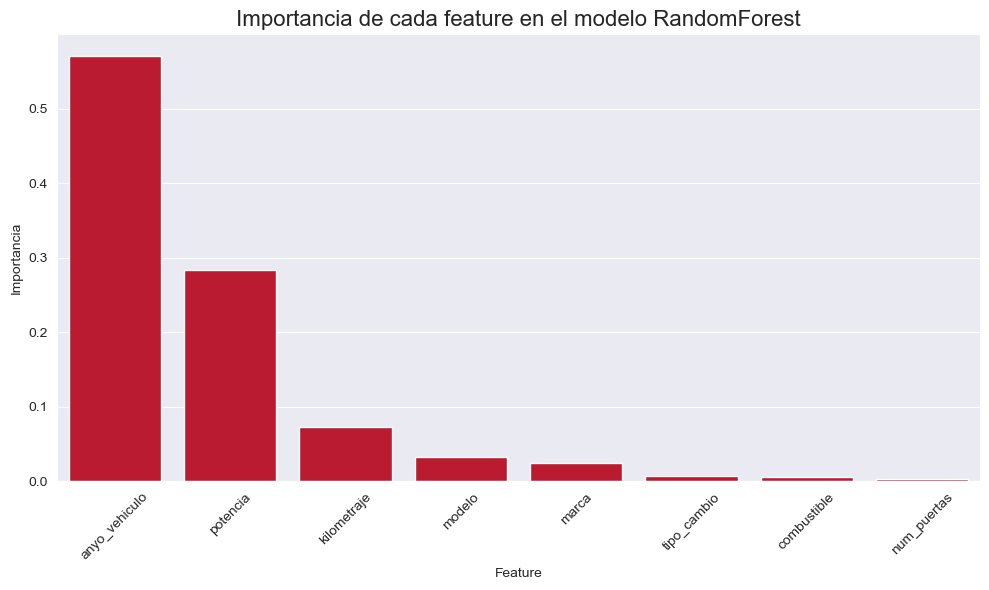

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6)) 


df_feat_imp_rf = df_feat_imp_rf.reset_index() 
df_feat_imp_rf.rename(columns={'index': 'Feature'}, inplace=True)

sns.barplot(data=df_feat_imp_rf, x='Feature', y='Feature Importance', color=colors[0])

plt.title("Importancia de cada feature en el modelo RandomForest", fontsize=16)
plt.xlabel("Feature")
plt.ylabel("Importancia")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Se observa cómo las columnas con más importancia en el precio de un coche de segunda mano son, según nuestro modelo RandomForest, el año de matriculación, potencia del motor y kms recorridos. Las columnas de modelo y marca del coche también tienen algo de importancia, y las demás (tipo de cambio, combustible y número de puertas) tienen una importancia mucho menor.

Por esto, vamos a probar a hacer un Random Forest, con la misma parametrización que el mejor de antes, pero quitando las columnas menos importantes: ```["tipo_cambio", "combustible", "num_puertas"]```, a ver si mejora el modelo.

In [91]:
# RF 2

X_rf_2 = X.drop(columns=["tipo_cambio", "combustible", "num_puertas"])
X_rf_2

,marca,modelo,anyo_vehiculo,kilometraje,potencia
0,1,356,2021.0,33200,190.0
1,6,29,2016.0,127300,110.0
2,7,143,2022.0,123000,100.0
3,2,92,2022.0,18150,83.0
4,9,110,2023.0,12000,150.0
...,...,...,...,...,...
29694,8,239,2019.0,21153,115.0
29695,7,237,2015.0,68750,150.0
29696,6,5,2019.0,21422,72.0
29697,0,289,2013.0,47900,450.0


In [92]:
from sklearn.model_selection import train_test_split

X_train_rf2, X_test_rf2, y_train_rf2, y_test_rf2 = train_test_split(X_rf_2, y, test_size=0.2, random_state=42)

print(X_train_rf2.shape)
print(X_test_rf2.shape)
print(y_train_rf2.shape)
print(y_test_rf2.shape)

(23759, 5)
(5940, 5)
(23759,)
(5940,)


In [93]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train_rf2)
X_train_rf2 = scaler.transform(X_train_rf2)
X_test_rf2 = scaler.transform(X_test_rf2)

In [94]:
# RandomForest

# param = {"n_estimators":[50, 100, 300], "max_depth":[3, 5, 9, 15, 33], "n_jobs":[-1], "random_state":[42]}

rf2 = RandomForestRegressor(n_estimators=300, max_depth=33, n_jobs=-1, random_state=42)

rf2.fit(X_train_rf2, y_train_rf2)

y_pred_rf2 = rf2.predict(X_test_rf2)

print(f"MSE: {metrics.mean_squared_error(y_test_rf2, y_pred_rf2)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test_rf2, y_pred_rf2))}")
print(f"MAE: {metrics.mean_absolute_error(y_test_rf2, y_pred_rf2)}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(y_test_rf2, y_pred_rf2)}")

print(f"r2 score: {metrics.r2_score(y_test_rf2, y_pred_rf2)}")

MSE: 0.055758710357681825
RMSE: 0.23613282354997117
MAE: 0.14799043130934064
MAPE: 0.016508326874130987
r2 score: 0.9197534543534175


### 4.2. Análisis del modelo definitivo:

Obtenemos un MSE más elevado que antes, por lo que no mejora. Nos quedamos entonces el XG Boost, que era el segundo modelo con el MSE más bajo pero más rápido que el primero. Vamos a ver la importancia de las features en este modelo:

In [95]:
xgb_model = xgboost.XGBRegressor()

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

print(f"MSE: {metrics.mean_squared_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}")
print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred)}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(y_test, y_pred)}")

print(f"r2 score: {metrics.r2_score(y_test, y_pred)}")

MSE: 0.04557942078419423
RMSE: 0.21349337409904373
MAE: 0.13764354696548495
MAPE: 0.015311936673952017
r2 score: 0.9344032340948909


In [96]:
X.columns

Index(['marca', 'modelo', 'combustible', 'anyo_vehiculo', 'kilometraje',
       'potencia', 'num_puertas', 'tipo_cambio'],
      dtype='object')

In [97]:
xgb_model.feature_importances_

array([0.05145216, 0.02008888, 0.01958242, 0.44428998, 0.03746107,
       0.21881962, 0.01699274, 0.19131315], dtype=float32)

In [100]:
df_feat_imp = pd.DataFrame(xgb_model.feature_importances_, index=X.columns)
df_feat_imp = df_feat_imp.rename(columns={0:"Feature Importance"}).sort_values("Feature Importance", ascending=False)
df_feat_imp

,Feature Importance
anyo_vehiculo,0.444290
potencia,0.218820
tipo_cambio,0.191313
marca,0.051452
kilometraje,0.037461
modelo,0.020089
combustible,0.019582
num_puertas,0.016993


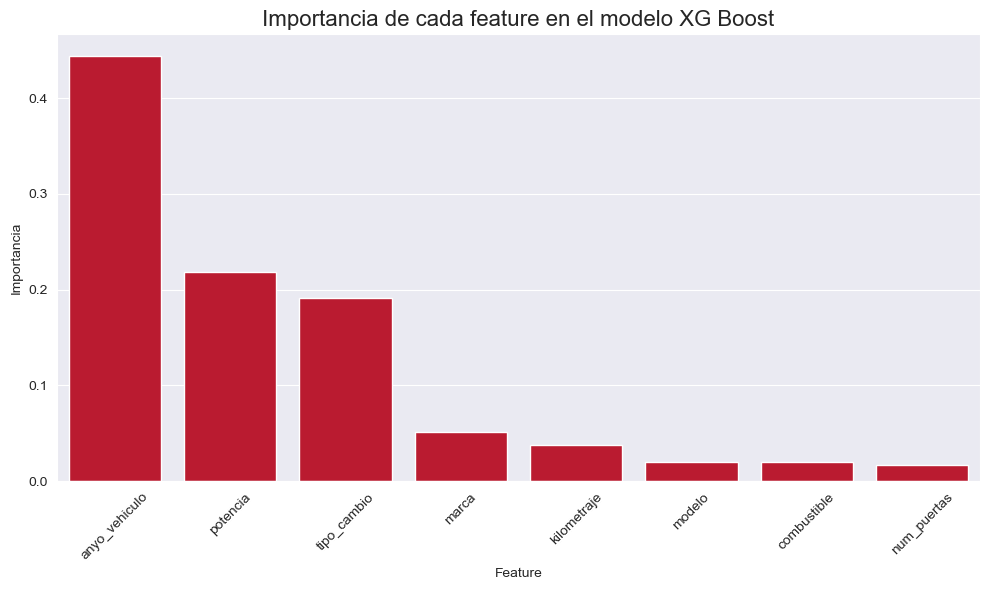

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

df_feat_imp = df_feat_imp.reset_index()
df_feat_imp.rename(columns={'index': 'Feature'}, inplace=True)

sns.barplot(data=df_feat_imp, x='Feature', y='Feature Importance', color=colors[0])

plt.title("Importancia de cada feature en el modelo XG Boost", fontsize=16)
plt.xlabel("Feature")
plt.ylabel("Importancia")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Ahora observamos que las columnas más importantes siguen siendo ```"anyo_vehiculo"``` y ```"potencia"```. Sin embargo, el XGBoost le da mucha más importancia a la columna ```"tipo_cambio"``` que el RandomForest previo, y menos a la columna ```"kilometraje"```. Además la importancia de las columnas menos importantes es más elevada que en el anterior modelo, por lo que no descartaremos ninguna de estas columnas.

Vamos a deshacer la transformación que realizamos en la columna ```"precio"``` (target) para ver la dimensión real de nuestras métricas:

In [104]:
y_pred = xgb_model.predict(X_test)

# Deshacemos la transformación logarítmica:
y_test_final = np.exp(y_test)
y_pred_final = np.exp(y_pred)

# Claculamos las métricas reales:
print(f"MSE: {metrics.mean_squared_error(y_test_final, y_pred_final)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test_final, y_pred_final))}")
print(f"MAE: {metrics.mean_absolute_error(y_test_final, y_pred_final)}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(y_test_final, y_pred_final)}")

print(f"r2 score: {metrics.r2_score(y_test_final, y_pred_final)}")

MSE: 14256628.19307195
RMSE: 3775.7950411895968
MAE: 1872.9885921902128
MAPE: 0.1405485106362972
r2 score: 0.9315665938523535


Vemos que el MAE = 1873 euros. Esto significa que para cada vehículo nos podemos ir esa cantidad de dinero de media en la predicción. 

El RMSE es algo mayor, 3776 euros, lo cual se debe a que existen unos pocos coches cuyo error es alto, y al hacer el error cuadrático este error se hace más grande.

En cuanto al MAPE, nos indica que nuestro modelo tiene un % de error medio del 14.05% sobre el precio del vehículo, el cual es algo elevado.

Vamos a exportar el modelo final:

In [107]:
import pickle

# Guardamos el modelo final:

with open("../include/model/modelo_final.pkl", 'wb') as archivo_salida:
    pickle.dump(xgb_model, archivo_salida)


Creamos una función que nos permita meter nuevos inputs en el formato de nuestro DataFrame inicial y extraer las variables para pasar directamente al modelo.

Además, creamos otras dos funciones: una para realizar predicciones y otra para destransformar la columna target ```"precio"```.

In [120]:
# Función para transformar un df con nuevos inputs de la base de datos en X, y para pasar al modelo.

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import pickle



def new_input_clean(input_df):
    '''
    Introduce los nuevos inputs en formato DataFrame con las columnas iniciales y devuelve los datos listos para introducirlos al modelo.

    El input DataFrame debe contener al menos las columnas (['marca', 'modelo', 'combustible', 'anyo_vehiculo', 'kilometraje', 'potencia', 
    'num_puertas', 'tipo_cambio'])
    '''

    excepciones = ['marca', 'modelo', 'precio', 'combustible', 'anyo_vehiculo', 'kilometraje', 'potencia', 'num_puertas', 'tipo_cambio']

    # Reemplazar NaN con 0 excepto en las columnas de excepciones (las que utiliza el modelo)
    input_df = input_df.fillna({col: 0 for col in input_df.columns if col not in excepciones})


    input_df = input_df[excepciones]
    input_df = input_df.drop(index=(input_df.loc[df.loc[:, "potencia"].isna() == True, :]).index)
    input_df = input_df.drop(index=(input_df.loc[df.loc[:, "tipo_cambio"].isna() == True, :]).index)
    input_df = input_df.dropna()

    # Importamos los encodings hechos antes:
    encoder_marca = pickle.load(open("../include/utils/label_encoder_marca.pkl", 'rb'))
    encoder_modelo = pickle.load(open("../include/utils/label_encoder_modelo.pkl", 'rb'))

    list(encoder_marca.classes_)
    input_df["marca"] = encoder_marca.transform(input_df["marca"])

    list(encoder_modelo.classes_)
    input_df["modelo"] = encoder_modelo.transform(input_df["modelo"])

    tipos_combustible = {"Diésel" : 0,
            "Gasolina" : 1,
            "Híbrido" : 2,
            "Eléctrico" : 3,
            "Híbrido enchufable" : 4, 
            "Gas licuado (GLP)" : 5,
            "Gas natural (CNG)" : 6}
                     
    input_df["combustible"] = input_df["combustible"].map(tipos_combustible)

    num_puertas = {5: 5,
            4 : 5,
            3 : 3,
            2 : 3}
    
    input_df["num_puertas"] = input_df["num_puertas"].map(num_puertas)
    
    input_df["tipo_cambio"] = input_df["tipo_cambio"].apply(lambda x: 0 if x == "Manual" else 1)

    input_df["precio"] = np.log(input_df["precio"])

    X_input = input_df.drop("precio", axis=1)
    y_input = input_df["precio"]
    

    scaler = pickle.load(open("../include/utils/scaler.pkl", 'rb'))

    X_input = scaler.transform(X_input)

    return [X_input, y_input]

# Función para hacer predicciones

def predict(loaded_model, X_input):
    return loaded_model.predict(X_input)

# Función para deshacer la transformación y devolver el precio:

import numpy as np

def destransformar_y(y_out):
    return np.exp(y_out)

Vamos ahora a cargar el modelo y probarlo con un DataFrame de prueba con coches, para ver el precio que predice. 

In [121]:
import pickle

loaded_model = pickle.load(open("../include/model/modelo_final.pkl", 'rb'))

In [122]:
loaded_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [123]:
import pandas as pd
import sqlite3

# Conexión a la BBDD:
con = sqlite3.connect("../include/db_vehiculos.db")

# Vamos a ver qué nos devuelve un select sobre la tabla:
query = """
SELECT * FROM TX_VEHICULOS_SEG_MANO
--where
--fecha_carga > '2025-05-11 22:33:00'
order by
    fecha_carga desc
;
"""

# Leemos los resultados en un DataFrame de pandas
df = pd.read_sql_query(query, con)

# Mostramos los primeros registros (aún no hay):
df_prueba = df.head()

df_prueba

,pk_anuncio_id,marca,modelo,precio,combustible,anyo_vehiculo,kilometraje,potencia,num_puertas,num_plazas,...,tipo_vehiculo,cilindrada_motor,color,provincia,etiqueta_eco,origen_anuncio,fecha_publicacion,anyomes_publicacion,fecha_carga,url
0,60498281,BMW,x3,37900.0,Híbrido,2021.0,33200,190.0,5.0,5.0,...,SUV,1995.0,gris,Madrid,ECO (azul/verde),WebScraping,2025-05-07,202505.0,2025-05-18 14:21:01,https://www.coches.net/bmw-x3-xdrive20d-xline-...
1,59710104,PEUGEOT,308,9000.0,Gasolina,2016.0,127300,110.0,5.0,5.0,...,Berlina,1199.0,blanco,Asturias,None,WebScraping,2025-01-25,202501.0,2025-05-18 11:18:51,https://www.coches.net/peugeot-308-5p-allure-1...
2,60479478,RENAULT,clio,11990.0,Diésel,2022.0,123000,100.0,5.0,5.0,...,Berlina,1461.0,blanco,Málaga,None,WebScraping,2025-05-18,202505.0,2025-05-18 10:06:26,https://www.coches.net/renault-clio-equilibre-...
3,60374025,CITROEN,c3,16500.0,Gasolina,2022.0,18150,83.0,5.0,5.0,...,Berlina,1199.0,blanco,Madrid,None,WebScraping,2025-04-19,202504.0,2025-05-18 10:05:00,https://www.coches.net/citroen-c3-puretech-60k...
4,60576644,VOLKSWAGEN,california,67900.0,Diesel,2023.0,12000,150.0,4.0,4.0,...,Monovolumen,1968.0,Blanco,Las Palmas,None,WebScraping,2025-05-18,202505.0,2025-05-18 07:24:21,https://www.coches.net/volkswagen-california-o...


In [124]:
X_input, y_input = new_input_clean(input_df=df_prueba)

In [125]:
predictions = loaded_model.predict(X_input)
predictions

array([10.6165085,  9.09715  ,  9.384863 ,  9.533099 , 10.874894 ],
      dtype=float32)

In [126]:
y_prueba = destransformar_y(predictions).round(0)
y_prueba

array([40803.,  8930., 11907., 13809., 52833.], dtype=float32)

Insertamos las predicciones realizadas en la columna ```"precio_predicho"```, al lado de la columna target ```"precio"```:

In [130]:
df_prueba.insert(4, "precio_predicho", y_prueba)
df_prueba.to_csv("../include/data/processed/df_prueba_pred.csv")
df_prueba

,pk_anuncio_id,marca,modelo,precio,precio_predicho,combustible,anyo_vehiculo,kilometraje,potencia,num_puertas,...,tipo_vehiculo,cilindrada_motor,color,provincia,etiqueta_eco,origen_anuncio,fecha_publicacion,anyomes_publicacion,fecha_carga,url
0,60498281,BMW,x3,37900.0,40803.0,Híbrido,2021.0,33200,190.0,5.0,...,SUV,1995.0,gris,Madrid,ECO (azul/verde),WebScraping,2025-05-07,202505.0,2025-05-18 14:21:01,https://www.coches.net/bmw-x3-xdrive20d-xline-...
1,59710104,PEUGEOT,308,9000.0,8930.0,Gasolina,2016.0,127300,110.0,5.0,...,Berlina,1199.0,blanco,Asturias,None,WebScraping,2025-01-25,202501.0,2025-05-18 11:18:51,https://www.coches.net/peugeot-308-5p-allure-1...
2,60479478,RENAULT,clio,11990.0,11907.0,Diésel,2022.0,123000,100.0,5.0,...,Berlina,1461.0,blanco,Málaga,None,WebScraping,2025-05-18,202505.0,2025-05-18 10:06:26,https://www.coches.net/renault-clio-equilibre-...
3,60374025,CITROEN,c3,16500.0,13809.0,Gasolina,2022.0,18150,83.0,5.0,...,Berlina,1199.0,blanco,Madrid,None,WebScraping,2025-04-19,202504.0,2025-05-18 10:05:00,https://www.coches.net/citroen-c3-puretech-60k...
4,60576644,VOLKSWAGEN,california,67900.0,52833.0,Diesel,2023.0,12000,150.0,4.0,...,Monovolumen,1968.0,Blanco,Las Palmas,None,WebScraping,2025-05-18,202505.0,2025-05-18 07:24:21,https://www.coches.net/volkswagen-california-o...


Vemos que los precios que predice el modelo se ajustan bastante a los reales. Para el vehículo VolksWagen California no lo predice bien, lo cual es más común que pase para vehículos fuera del rango de precio entre 5.000 y 25.000 euros, que era donde más cantidad había.

Registros de VolksWagen California:

In [133]:
import pandas as pd
import sqlite3

# Conexión a la BBDD:
con = sqlite3.connect("../include/db_vehiculos.db")

# Vamos a ver qué nos devuelve un select sobre la tabla:
query = """
SELECT * FROM TX_VEHICULOS_SEG_MANO
where
    marca = 'VOLKSWAGEN'
    and modelo = 'california'
;
"""

# Leemos los resultados en un DataFrame de pandas
df_vw_california = pd.read_sql_query(query, con)

# Mostramos los primeros registros (aún no hay):

# df_vw_california

## Idea: división en segmentos.

1. Segmento medio: hasta 25k eur.
2. Segmento premium: desde 25k eur.